In [1]:
!pip install graphviz
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
data = {
    'Age': ['<=30','<=30','31-40','>40','>40','>40','31-40','<=30','<=30','>40','<=30','31-40','31-40','>40'],
    'Income': ['High','High','High','Medium','Low','Low','Low','Medium','Low','Medium','Medium','Medium','High','Medium'],
    'Student': ['No','No','No','No','Yes','Yes','Yes','No','Yes','Yes','Yes','No','Yes','No'],
    'Credit_rating': ['Fair','Excellent','Fair','Fair','Fair','Excellent','Excellent','Fair','Fair','Fair','Excellent','Excellent','Fair','Excellent'],
    'Buy_Laptop': ['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']
}
df = pd.DataFrame(data)

In [3]:
df

,Age,Income,Student,Credit_rating,Buy_Laptop
0,<=30,High,No,Fair,No
1,<=30,High,No,Excellent,No
2,31-40,High,No,Fair,Yes
3,>40,Medium,No,Fair,Yes
4,>40,Low,Yes,Fair,Yes
5,>40,Low,Yes,Excellent,No
6,31-40,Low,Yes,Excellent,Yes
7,<=30,Medium,No,Fair,No
8,<=30,Low,Yes,Fair,Yes
9,>40,Medium,Yes,Fair,Yes


In [4]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = 0
    for i in range(len(elements)):
        prob = counts[i] / np.sum(counts)
        entropy += -prob * np.log2(prob)
    return entropy

In [5]:
def InfoGain(data, split_attribute_name, target_name="Buy_Laptop"):
    total_entropy = entropy(data[target_name])
    
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)
    weighted_entropy = 0
    for i in range(len(vals)):
        subset = data[data[split_attribute_name] == vals[i]]
        weighted_entropy += (counts[i]/np.sum(counts)) * entropy(subset[target_name])
    
    Information_Gain = total_entropy - weighted_entropy
    return Information_Gain

In [6]:
def id3(data, features, target_attribute_name="Buy_Laptop", parent_node_class=None):
    # If all target values have the same label, return that label
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    # If dataset is empty, return most common label from original data
    elif len(data) == 0:
        return parent_node_class
    
    # If no features left, return parent class
    elif len(features) == 0:
        return parent_node_class
    
    # Save most common label at current node
    parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]
    
    # Choose best feature
    item_values = [InfoGain(data, feature, target_attribute_name) for feature in features]
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]
    
    tree = {best_feature: {}}
    features = [f for f in features if f != best_feature]
    
    for value in np.unique(data[best_feature]):
        subset = data[data[best_feature] == value]
        subtree = id3(subset, features, target_attribute_name, parent_node_class)
        tree[best_feature][value] = subtree
    
    return tree

In [7]:
def predict(tree, instance):
    if not isinstance(tree, dict):
        return tree
    attr = next(iter(tree))
    val = instance.get(attr)
    if val not in tree[attr]:
        return "Unknown"  # Fallback for unseen attribute value
    return predict(tree[attr][val], instance)

In [8]:
attributes = list(df.columns[:-1])
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
tree = id3(train_df, attributes)

# Predict on test set
y_true = test_df['Buy_Laptop']
y_pred = test_df.apply(lambda row: predict(tree, row), axis=1)
print("\nTrue Labels:\n", list(y_true))
print("Predictions:\n", list(y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


True Labels:
 ['Yes', 'Yes', 'No', 'Yes', 'No']
Predictions:
 ['Yes', 'Yes', 'No', 'Yes', 'Yes']
Accuracy: 0.8


In [9]:
from graphviz import Digraph

def visualize_tree(tree, parent_name='', graph=None, node_id=[0]):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box')
    
    current_node = str(node_id[0])
    node_id[0] += 1

    if isinstance(tree, dict):
        attr = next(iter(tree))
        graph.node(current_node, attr)

        if parent_name != '':
            graph.edge(parent_name, current_node)

        for val, subtree in tree[attr].items():
            child_id = str(node_id[0])
            if isinstance(subtree, dict):
                visualize_tree(subtree, current_node, graph, node_id)
                graph.edge(current_node, str(node_id[0] - 1), label=str(val))
            else:
                graph.node(child_id, subtree, shape='ellipse')
                graph.edge(current_node, child_id, label=str(val))
                node_id[0] += 1
    else:
        graph.node(current_node, tree, shape='ellipse')
        if parent_name != '':
            graph.edge(parent_name, current_node)

    return graph

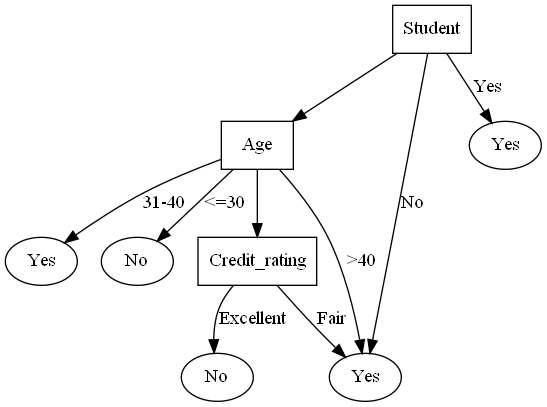

In [24]:
graph = visualize_tree(tree)
graph.render('id3_tree', format='jpg', cleanup=False)
from IPython.display import Image
Image(filename='id3_tree.png')